# Python for Finance, Part 2: Intro to Quantitative Trading Strategies

In the previous article of this series, we focused on using Python and Pandas to 

1. retrieve financial time-series from free online sources (Yahoo),
2. format the data by filling missing observations and aligning them,
3. calculate some simple indicators such as rolling moving averages and
4. visualise the final time-series.

As a reminder, the dataframe containing the three "cleaned" price timeseries has the following format:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_pickle('./data.pkl')
data.head(10)

,AAPL,MSFT,^GSPC
2000-01-03,3.625643,39.334630,1455.219971
2000-01-04,3.319964,38.005900,1399.420044
2000-01-05,3.368548,38.406628,1402.109985
2000-01-06,3.077039,37.120080,1403.449951
2000-01-07,3.222794,37.605172,1441.469971
2000-01-10,3.166112,37.879354,1457.599976
2000-01-11,3.004162,36.909170,1438.560059
2000-01-12,2.823993,35.706986,1432.250000
2000-01-13,3.133722,36.381897,1449.680054
2000-01-14,3.253159,37.879354,1465.150024


We have also calculated the rolling moving averages of these three timeseries as follows. Note that when calculating the $M$ days moving average, the first $M-1$ are not valid, as $M$ prices are required for the first moving average data point.

In [2]:
# Calculating the short-window moving average
short_rolling = data.rolling(window=20).mean()
short_rolling.head()

,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN


In [3]:
# Calculating the short-window moving average
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()

,AAPL,MSFT,^GSPC
2016-12-26,110.958205,58.418182,2176.628791
2016-12-27,111.047874,58.476117,2177.500190
2016-12-28,111.140589,58.532936,2178.244490
2016-12-29,111.233698,58.586112,2178.879189
2016-12-30,111.315270,58.635267,2179.426990


Building on these results, our ultimate goal will be to design a simple yet realistic trading strategy. However, first we need to go through some of the basic concepts related to quantitative trading strategies, as well as the tools and techniques in the process.

## General considerations about trading strategies

There are several ways one can go about when a trading strategy is to be developed. One approach would be to use the price time-series directly and work with numbers that correspond to some monetary value. For example, a researcher could be working with time-series expressing the price of a given stock, like the time-series we used in the previous article. Similarly, if working with fixed income instruments, e.g. bonds, one could be using a time-series expressing the price of the bond as a percentage of a given reference value, in this case the par value of the bond. Working with this type of time-series can be more intuitive as people are used to thinking in terms of prices. However, price time-series have some drawbacks. Prices are usually only positive, which makes it harder to use models and approaches which require or produce negative numbers. In addition, price time-series are usually non-stationary, that is their statistical properties are less stable over time.

An alternative approach is to use time-series which correspond not to actual values but changes in the monetary value of the asset. These time-series can and do assume negative values and also, their statistical properties are usually more stable than the ones of price time-series. The most frequently used forms used are relative returns defined as

\begin{equation}
r_{\text{relative}}\left(t\right) = \frac{p\left(t\right) - p\left(t-1\right)}{p\left(t-1\right)}
\end{equation}

and log-returns defined as

\begin{equation}
r\left(t\right) = \log\left( \frac{p\left(t\right)}{p\left(t-1\right)} \right)
\end{equation}

where $p\left(t\right)$ is the price of the asset at time $t$. For example, if $p\left(t\right) = 101$ and $p\left(t-1\right) = 100$ then $r_{\text{relative}}\left(t\right) = \frac{101 - 100}{100} = 1\%$.

There are several reasons why log-returns are being used in the industry and some of them are related to long-standing assumptions about the behaviour of asset returns and are out of our scope. However, what we need to point out are two quite interesting properties. Log-returns are additive and this facilitates treatment of our time-series, relative returns are not. We can see the additivity of log-returns in the following equation.

\begin{equation}
r\left(t_1\right) + r\left(t_2\right) =  \log\left( \frac{p\left(t_1\right)}{p\left(t_0\right)} \right) + 
\log\left( \frac{p\left(t_2\right)}{p\left(t_1\right)} \right) = \log\left( \frac{p\left(t_2\right)}{p\left(t_0\right)} \right)
\end{equation}

which is simply the log-return from $t_0$ to $t_2$. Secondly, log-returns are approximately equal to the relative returns for  values of $\frac{p\left(t\right)}{p\left(t-1\right)}$ sufficiently close to $1$. By taking the 1st order Taylor expansion of $\log\left( \frac{p\left(t\right)}{p\left(t-1\right)} \right)$ around $1$, we get

\begin{equation}
\log\left( \frac{p\left(t\right)}{p\left(t-1\right)} \right) \simeq \log\left(1\right) + 
\frac{p\left(t\right)}{p\left(t-1\right)} - 1 = r_{\text{relative}}\left(t\right)
\end{equation}

Both of these are trivially calculated using Pandas as:

In [4]:
# Relative returns
returns = data.pct_change(1)
returns.head()

,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.084310,-0.033780,-0.038345
2000-01-05,0.014634,0.010544,0.001922
2000-01-06,-0.086538,-0.033498,0.000956
2000-01-07,0.047369,0.013068,0.027090


In [5]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
log_returns = np.log(data).diff()
log_returns.head()

,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.088078,-0.034364,-0.039099
2000-01-05,0.014528,0.010489,0.001920
2000-01-06,-0.090514,-0.034072,0.000955
2000-01-07,0.046281,0.012984,0.026730


Since log-returns are additive, we can create the time-series of cumulative log-returns defined as

\begin{equation}
c\left(t\right) = \sum_{k=1}^t r\left(t\right)
\end{equation}

The cumulative log-returns and the total relative returns from 2000/01/01 for the three time-series can be seen below. Note that although log-returns are easy to manipulate, investors are accustomed to using relative returns. For example, a log-return of $1$ does not mean an investor has doubled the value of his portfolio. A relative return of $1 = 100\%$ does! Converting between the cumulative log-return $c\left(t\right)$ and the total relative return $c_{\text{relative}}\left(t\right) = \frac{p\left(t\right) - p\left(t_o\right)}{p\left(t_o\right)}$ is simple
$$ c_{\text{relative}}\left(t\right) = e^{c\left(t\right)} - 1 $$

For those who are wondering if this is correct, yes it is. If someone had bought $\$1000$ worth of AAPL shares in January 2000, her/his portfolio would now be worth over $\$30,000$. If only we had a time machine... 

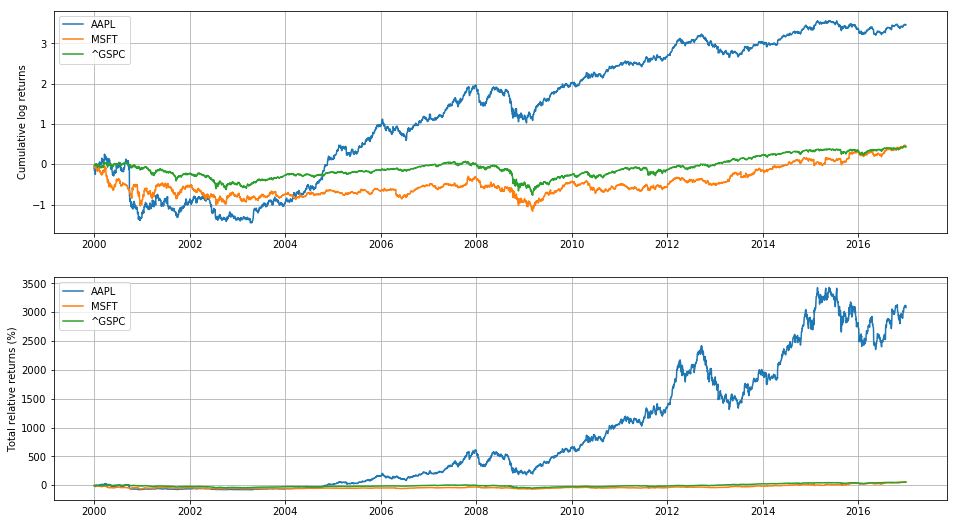

In [6]:
fig = plt.figure(figsize=[16,9])

ax = fig.add_subplot(2,1,1)

for c in log_returns:
    ax.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax.set_ylabel('Cumulative log returns')
ax.legend(loc='best')
ax.grid()

ax = fig.add_subplot(2,1,2)

for c in log_returns:
    ax.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax.set_ylabel('Total relative returns (%)')
ax.legend(loc='best')
ax.grid()

plt.show()

## What is a quantitative trading strategy?

Our goal is to develop a toy trading strategy, but what does the term "quantitative trading strategy" actually mean? In this section we will give a definition that will guide us in our long-term goal. 

Assume we have at our disposal a certain amount of dollars, $N$, which we are interested to invest. We have at our disposal a set of $K$ assets from which we can buy and sell freely any arbitrary amount. Our goal is to derive weights $w_i\left(t\right), i = 1, \ldots, K$ such that 

$$w_i\left(t\right) \in \mathbb{R} \ \text{and} \ \sum_{i=1}^K w_i\left(t\right) \leq 1$$

so that an amount of dollars equal to $w_i\left(t\right) N$ is invested at time $t$ on asset $i$. 

The inequality condition signifies $\sum_{i=1}^K w_i\left(t\right) \leq 1$ that the maximum amount we can invest is equal to amount of dollars we have, that is $N$.

<p class="example">For example, assume we can invest in $2$ instruments only and that $N=\$1000$. The goal is to derive two weights $w_1\left(t\right)$ and $w_2\left(t\right)$.
If at some point $w_1\left(t\right) = 0.4$ and $w_2\left(t\right) = 0.6$, this means that we have invested $w_1\left(t\right)N = \$400$ in asset $1$ and $w_2\left(t\right)N = \$600$ in asset $2$. Since we only have $\$1000$, we can only invest up to that much which means that
$$w_1\left(t\right)N + w_2\left(t\right)N \leq N \Rightarrow w_1\left(t\right) + w_2\left(t\right) < 1$$.
</p>

Note that since we have allowed $w_i\left(t\right)$ to be any real number, we are implying that we are allowed to have negative weights. Negative weights imply that we have sold a given asset short. Selling short an asset means selling an asset we do not currently hold and receiving its value in cash. Selling short is different than selling an asset we already own, which is called selling long. 

The mechanics behind this can be complicated and are usually subject to regulatory scrutiny. However, on a high level, it involves borrowing the asset from a third party and then selling it to the buyer. Since at some point the asset needs to be returned to the party from which it was borrowed, the short position needs to be closed. This is achieved by buying the asset back from the original buyer or any other willing seller. For the purpose of this article it will be assumed that selling an asset short can be accomplished at no added cost, an assumption which is not true.

<span class="note">More on selling long vs. selling short [here](http://www.investopedia.com/ask/answers/100314/whats-difference-between-long-and-short-position-market.asp).</span>

The assuming that the weights can be unbounded is not realistic. For example, based on the definition given above we could sell short an amount of AAPL shares of value equal to $N$. This means that, for now, we have at our disposal an additional $N$ dollars to invest from the short sale. Thus, together with our original $N$ dollars, we can the purchase shares of MSFT worth $2N$ dollars. In our framework, this translates to $w_{\text{AAPL}}=-1$ and $w_{\text{MSFT}}=2$. In theory, the weights could be $-999$ and $1000$ respectively. However, an increase in the absolute values of the weights leads to an increase in the risk of our portfolio for reasons we will see further down this series of tutorials. Therefore, when developing our trading strategy, appropriate thresholds will be imposed on the weights $w_i\left(t\right)$.

A final note has to do with cash. Any portfolio will at some point in time include cash. In the aforementioned setup if at any point in time $W = \sum_{i=1}^K w_i\left(t\right) < 1$, then it means that our portfolio includes $\left(1-W\right)N$ dollars in cash. Of course, if $W<0$, our net position is short, which means we are currently holding more than $N$ dollars which is the initial value of the portfolio.

## Putting it all together

For the remaining of this series of tutorials we will assume (unless explicitly stated) that $N=\$1$. This will allow us to simplify the notation and all calculations and only deal with the weights $w_i\left(t\right)$ of the strategy which will be pure numbers. We can always convert back to a monetary value by simply multiplying our dimensionless weights with $N$, the value of the portfolio in dollars (or any other currency of interest). We will also assume that daily returns of the different assets are small enough, so that log-returns are roughly equal to relative returns. Thus, in what follows we will be using the log-returns. 

Assume that somehow we have what we think is a promising strategy, which is simply a vector

\begin{equation}
\vec{w}\left(t\right) = \left[ w_1\left(t\right), w_2\left(t\right), \ldots, w_K\left(t\right) \right]^T \in \mathbb{R}^{K \times 1}
\end{equation}

Then, if $\vec{r}\left(t\right)$ is a column vector of relative returns for the assets in the portfolio, the total log-return $r_p\left(t\right)$ for each $t$ is simply

\begin{equation}
\begin{aligned}
r_p\left(t\right) &= \vec{w}^T\left(t\right) \vec{r}\left(t\right) \\
&= w_1\left(t\right) r_1\left(t\right) + \ldots + w_K\left(t\right) r_K\left(t\right)
\end{aligned}
\end{equation}

Let us assume we are are using the last day in our dataset and $w_1 = w_2 = w_3 = \frac{1}{3}$. Then:

In [7]:
# Last day returns. Make this a column vector
r_t = log_returns.tail(1).transpose()
r_t

,2016-12-30 00:00:00
AAPL,-0.007826
MSFT,-0.012156
^GSPC,-0.004648


In [8]:
# Weights as defined above
weights_vector = pd.DataFrame(1 / 3, index=r_t.index, columns=r_t.columns)
weights_vector

,2016-12-30 00:00:00
AAPL,0.333333
MSFT,0.333333
^GSPC,0.333333


In [9]:
# Total log_return for the portfolio is:
portfolio_log_return = weights_vector.transpose().dot(r_t)
portfolio_log_return

,2016-12-30 00:00:00
2016-12-30,-0.00821


If computer memory is not an issue, a very fast way of computing the portfolio returns for all days, $t = 1, \ldots, T$ is the following: 

Assume that $\mathbf{R} \in \mathbb{R}^{T \times K}$ is a matrix, the $t$th row of which is the row vector $\vec{r}\left(t\right)^T$. Similarly, $\mathbf{W} \in \mathbb{R}^{T \times K}$ is a matrix, the $t$th row of which is the row vector $\vec{w}\left(t\right)^T$. Then if $\vec{r}_p = \left[ r_p\left(1\right), \ldots, r_p\left(T\right) \right]^T \in \mathbf{R}^{T \times 1}$ is a column vector of all portfolio returns, we have

$$\vec{r}_p = \text{diag}\left\{ \mathbf{W} \mathbf{R}^T \right\}$$

where $\text{diag}\left\{A \right\}$ is the diagonal of a matrix $\mathbf{A}$. The diagonal extraction is required because only in the diagonal the weights and log-returns vectors are properly time-aligned.

## An example

To illustrate the concepts of the previous section, let us consider a very simple trading strategy, where the investor splits his investments equally among all three assets we have been looking at. That is:

$$ w_{\text{AAPL}} = w_{\text{MSFT}} = w_{\text{^GSPC}} = \frac{1}{3} $$

In this case matrix $\mathbf{W}$ will be:

In [10]:
weights_matrix = pd.DataFrame(1 / 3, index=data.index, columns=data.columns)
weights_matrix.tail()

,AAPL,MSFT,^GSPC
2016-12-26,0.333333,0.333333,0.333333
2016-12-27,0.333333,0.333333,0.333333
2016-12-28,0.333333,0.333333,0.333333
2016-12-29,0.333333,0.333333,0.333333
2016-12-30,0.333333,0.333333,0.333333


Matrix $\mathbf{R}$ is simply our log-returns dataframe defined before.

In [11]:
log_returns.head()

,AAPL,MSFT,^GSPC
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.088078,-0.034364,-0.039099
2000-01-05,0.014528,0.010489,0.001920
2000-01-06,-0.090514,-0.034072,0.000955
2000-01-07,0.046281,0.012984,0.026730


Thus, the portfolio returns are calculated as:

In [12]:
# Initially the two matrices are multiplied. Note that we are only interested in the diagonal, 
# which is where the dates in the row-index and the column-index match.
temp_var = weights_matrix.dot(log_returns.transpose())
temp_var.head().ix[:, 0:5]

,2000-01-03 00:00:00,2000-01-04 00:00:00,2000-01-05 00:00:00,2000-01-06 00:00:00,2000-01-07 00:00:00
2000-01-03,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-04,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-05,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-06,NaN,-0.053847,0.008979,-0.04121,0.028665
2000-01-07,NaN,-0.053847,0.008979,-0.04121,0.028665


In [13]:
# The numpy np.diag function is used to extract the diagonal and then
# a Series is constructed using the time information from the log_returns index
portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.tail()

2016-12-26    0.000000
2016-12-27    0.003070
2016-12-28   -0.005753
2016-12-29   -0.000660
2016-12-30   -0.008210
Freq: B, dtype: float64

Note that these returns are only estimates because of our use of log-returns instead of relative returns. However, for most practical purposes the difference is negligible. Let us see what our cumulative log returns and the total relative returns for this portfolio look.

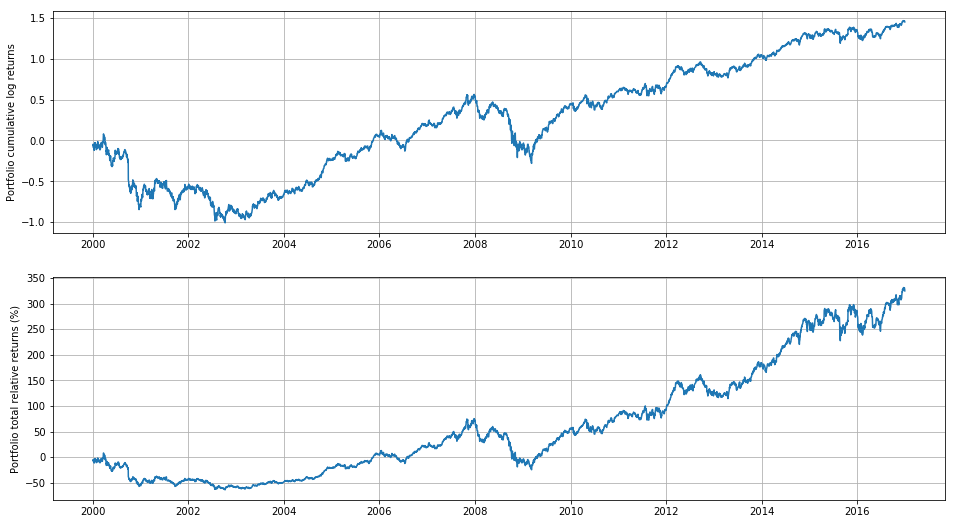

In [14]:
total_relative_returns = (np.exp(portfolio_log_returns.cumsum()) - 1)

fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(2, 1, 1)
ax.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax.set_ylabel('Portfolio cumulative log returns')
ax.grid()
ax = fig.add_subplot(2, 1, 2)
ax.plot(total_relative_returns.index, 100 * total_relative_returns)
ax.set_ylabel('Portfolio total relative returns (%)')
ax.grid()
plt.show()

So this simple investing strategy would yield a total return of more than $325\%$ in the course of almost $16$ years. 

How does this translate to a yearly performance? Since we have kept all weekdays in our portfolio, there are $52 \times 5 = 260$ weekdays each year. There are $4435$ days in our simulation which corresponds roughly to $16.92$ years. We will be calculating the average geometric return, that is an average return $\bar{r}$ which when compounded for $16.92$ years will produce the total relative return of $325.14\%$. So we need to solve:

\begin{equation}
\left(1 + \bar{r}\right)^{16.92} = 1 + 3.2514
\end{equation}

In [15]:
# Calculating the time-related parameters of the simulation
days_per_year = 52 * 5
total_days_in_simulation = data.shape[0]
number_of_years = total_days_in_simulation / days_per_year

# The last data point will give us the total portfolio return
total_portfolio_return = total_relative_returns[-1]
# Average portfolio return assuming compunding of returns
average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('Total portfolio return is: ' +
      '{:5.2f}'.format(100 * total_portfolio_return) + '%')
print('Average yearly return is: ' +
      '{:5.2f}'.format(100 * average_yearly_return) + '%')

Total portfolio return is: 325.14%
Average yearly return is:  8.85%


## What next?

Our strategy is a very simple example of a buy-and-hold strategy. The investor simply splits up the available funds in the three assets and keeps the same position throughout the period under investigation. Although simple, the strategy does produce a healthy $8.85\%$ per year. 

However, the simulation is not completely accurate. Let us not forget that we have used ALL weekdays in our example, but we do know that on some days the markets are not trading. This will not affect the strategy we presented as the returns on the days the markets are closed are 0, but it may potentially affect other types of strategies. Furthermore, the weights here are constant over time. Ideally, we would like weights that change over time so that we can take advantage of price swings and other market events.

Also, we have said nothing at all about the risk of this strategy. Risk is the most important consideration in any investment strategy and is closely related to the expected returns. In what follows, we will start designing a more complex strategy, the weights of which will not be constant over time. At the same time we will start looking into the risk of the strategy and present appropriate metrics to measure it. Finally, we will look into the issue of optimizing  the strategy parameters and how this can improve our return to risk profile.